In [1]:
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

#this code below is to make %%time magic work
import glob
import os
from __future__ import print_function
#this code above is to make %%time magic work

In [2]:
# Loading in HTML/CSS packages for use within the notebook
from IPython.core.display import HTML
HTML("<link href='https://fonts.googleapis.com/css?family=Passion+One' rel='stylesheet' type='text/css'><style>div.attn { font-family: 'Helvetica Neue'; font-size: 30px; line-height: 40px; color: #FFFFFF; text-align: center; margin: 30px 0; border-width: 10px 0; border-style: solid; border-color: #5AAAAA; padding: 30px 0; background-color: #DDDDFF; }hr { border: 0; background-color: #ffffff; border-top: 1px solid black; }hr.major { border-top: 10px solid #5AAA5A; }hr.minor { border: none; background-color: #ffffff; border-top: 5px dotted #CC3333; }div.bubble { width: 65%; padding: 20px; background: #DDDDDD; border-radius: 15px; margin: 0 auto; font-style: italic; color: #f00; }em { color: #AAA; }div.c1{visibility:hidden;margin:0;height:0;}div.note{color:red;}</style>")

In [3]:
#for easy of use, created a new csv file one hot encoded with all medications, and all numerical variables 
#also because RF and XGBOOST algos do not have any assumptions on multicolinearity
# in addition, tried with SVM_SGD, add all  medications, and all numerical variables did increase the acc comparing with insulin-only model.
#the trade off is takes a bit longer to run SVC. 
#but the goal is to tune parameters to achieve better performance in terms of better prediction, so I decide to include all the above variables.
#so import data from this csv file from now on, do not need to do the above data preprocessing


#decided on the features to include and 
#import the data
directory = 'C:/Users/N1110/Desktop/7331_Project/data/'
df = pd.read_csv(directory + 'Diabetes_Imputed_Cleaned.csv')
df_imputed = df
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Columns: 245 entries, meds_increased to readmitted_tf
dtypes: int64(245)
memory usage: 190.2 MB


In [4]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'readmitted_tf' in df_imputed:
    y = df_imputed['readmitted_tf'].values # get the labels we want
    del df_imputed['readmitted_tf'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [5]:
## Training and Testing Split
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

In [6]:
    # we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(X_train)
X_test_scaled = scl_obj.transform(X_test)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Random Forest

An ensemble approach to finding the decision tree that best fits the training data by creating many decision trees and then determining the "average" one. The "random" part of the term refers to building each of the decision trees from a random selection of features; the "forest" refers to the set of decision trees.
https://developers.google.com/machine-learning/glossary


In [7]:
#RF baseline model
%%time
#run for 1-2 mins
NUM_ESTIMATORS = 100
NO_JOBS = 4
RANDOM_STATE = 2000        
        
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(  random_state = RANDOM_STATE, criterion = 'gini', 
                                n_estimators = NUM_ESTIMATORS, verbose = False, n_jobs = NO_JOBS)
rf_clf.fit(X_train_scaled,y_train)

preds = rf_clf.predict(X_test_scaled)
print('Random Forest - roc_auc_score: ', roc_auc_score(y_test, preds)) 

#before Hyperparameter Tuning  
#run 1 Random Forest - roc_auc_score:  0.6691330626808287
#run 2 Random Forest - roc_auc_score:  0.6746304273089445

# The reason I want to keep both baseline model and refined model is to show the effect of Hyperparameter Tuning,
#increase the AUC by what percentage

Random Forest - roc_auc_score:  0.6746304273089445


In [15]:
from pprint import pprint

# Look at parameters used by our current base model forest
print('Parameters currently in use:\n')
pprint(rf_clf.get_params())




#Parameters currently in use:

#{'bootstrap': True,
# 'class_weight': None,
# 'criterion': 'gini',
# 'max_depth': None,
# 'max_features': 'auto',
# 'max_leaf_nodes': None,
# 'min_impurity_decrease': 0.0,
# 'min_impurity_split': None,
# 'min_samples_leaf': 1,
# 'min_samples_split': 2,
# 'min_weight_fraction_leaf': 0.0,
# 'n_estimators': 100,
# 'n_jobs': 4,
# 'oob_score': False,
# 'random_state': 2000,
# 'verbose': False,
# 'warm_start': False}

Parameters currently in use:

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': 4,
 'oob_score': False,
 'random_state': 2000,
 'verbose': False,
 'warm_start': False}


## Hyperparameter Tuning - Random Forest 

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/

https://github.com/WillKoehrsen/Machine-Learning-Projects/tree/master/random_forest_explained


We will try adjusting the following set of hyperparameters:

    n_estimators = number of trees in the foreset (more trees make the model more stable)
    max_features = max number of features considered for splitting a node
    max_depth = max number of levels in each decision tree
    min_samples_split = min number of data points placed in a node before the node is split
    min_samples_leaf = min number of data points allowed in a leaf node
    bootstrap = method for sampling data points (with or without replacement)

1. RandomizedSearchCV


2. Grid Search with Cross Validation

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV.

## Comparing randomized search and grid search for hyperparameter estimation

The randomized search and the grid search explore exactly the same space of parameters. The result in parameter settings is quite similar, while the run time for randomized search is drastically lower.

The performance is slightly worse for the randomized search, though this is most likely a noise effect and would not carry over to a held-out test set.

https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html



In [ ]:
## Random Search Training

#from previous assignment MiniLab1, I figured subsampling with 20% of data and do GridSearch for SVM reduce the run time sigificantly.
#and yield the same tuning results.
#from 4 hrs to 20 mins, that is 8x of time
#so I decide to do this again to save some training time. Train for the entire dataset ues the same code,just takes much longer.



In [4]:
#subsample 20% of our data 

subsam_df_imputed=df_imputed.sample(frac=0.2)

In [5]:
subsam_df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20353 entries, 78882 to 54883
Columns: 245 entries, meds_increased to readmitted_tf
dtypes: int64(245)
memory usage: 38.2 MB


In [6]:
df_imputed=subsam_df_imputed
df_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20353 entries, 78882 to 54883
Columns: 245 entries, meds_increased to readmitted_tf
dtypes: int64(245)
memory usage: 38.2 MB


In [7]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'readmitted_tf' in df_imputed:
    y = df_imputed['readmitted_tf'].values # get the labels we want
    del df_imputed['readmitted_tf'] # get rid of the class label
    X = df_imputed.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [8]:
## Training and Testing Split
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]

    # we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)
# to Make things easier, let's start by just using whatever was last stored in the variables:
##    X_train , y_train , X_test, y_test (they were set in a for loop above)
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

scl_obj.fit(X_train)
X_test_scaled = scl_obj.transform(X_test)

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\N1110\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


## Random Hyperparameter Grid - RandomizedSearchCV

In [16]:
#Random Hyperparameter Grid - RandomizedSearchCV

#To use RandomizedSearchCV, we first need to create a parameter grid to sample from during fitting

from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


On each iteration, the algorithm will choose a difference combination of the features. Altogether, there are 2 * 12 * 2 * 3 * 3 * 10 = 4320 settings! However, the benefit of a random search is that we are not trying every combination, but selecting at random to sample a wide range of values.

In [18]:
#run for 1hr

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100? different combinations, and (use all available cores-n job =-1)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 1, cv = 3, verbose=False, random_state=2000, n_jobs = 4)

# Fit the random search model
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=1, n_jobs=4,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=2000, refit=True,
          return_train_score='warn', scoring=None, verbose=False)

The most important arguments in RandomizedSearchCV are n_iter, which controls the number of different combinations to try, and cv which is the number of folds to use for cross validation (we use 5 and 3 respectively). (start n_iter with a small number to get estimation of runtime) (Fitting 3 folds for each of 5 candidates, totalling 15 fits-see if it is around 15 mins, since base model run for 1 min-for full dataset) (running for 15 mins now, still running) (running for half an hour and still runing.so stopped and change n iter to 1, just try to see how much time it will take)

More iterations will cover a wider search space and more cv folds reduces the chances of overfitting, but raising each will increase the run time. Machine learning is a field of trade-offs, and performance vs time is one of the most fundamental.

In [19]:
#view the best parameters from fitting the random search:
rf_random.best_params_


#Out[19]:
#{'n_estimators': 1800,
# 'min_samples_split': 10,
# 'min_samples_leaf': 1,
# 'max_features': 'sqrt',
# 'max_depth': 50,
# 'bootstrap': False}

{'n_estimators': 1800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [23]:
#Evaluate Random Search
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
Average Error: 0.3454 degrees.
Accuracy = nan%.


In [24]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
Average Error: 0.3102 degrees.
Accuracy = nan%.


In [25]:
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of nan%.


In [17]:
#run for 5 mins  n_estimators = 1800  (base model n_estimators = 100)

#evaulate the performance of the model best parameters
#test the improvement of auc using rf_random.best_params_

#Out[19]:
#{'n_estimators': 1800,
# 'min_samples_split': 10,
# 'min_samples_leaf': 1,
# 'max_features': 'sqrt',
# 'max_depth': 50,
# 'bootstrap': False}

rf_clf = RandomForestClassifier(  random_state = RANDOM_STATE, criterion = 'gini', min_samples_split=10,min_samples_leaf=1,
                                max_features='sqrt', max_depth=50, bootstrap = False,
                                n_estimators = 1800, verbose = False, n_jobs = NO_JOBS)
rf_clf.fit(X_train_scaled,y_train)

preds = rf_clf.predict(X_test_scaled)
print('Random Forest - roc_auc_score: ', roc_auc_score(y_test, preds)) 
#Random Forest - roc_auc_score:  0.6797954420410847
#run2 Random Forest - roc_auc_score:  0.6776931710399214

Random Forest - roc_auc_score:  0.6776931710399214


In [18]:
random_accuracy = 0.6776931710399214
base_accuracy =0.6682573532018597

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Improvement of 1.41%.


## Grid Search with Cross Validation - GridSearchCV

In [10]:
#Grid Search with Cross Validation
#use smaller list of param for the sake of time, only a few numbers, not garantee best solution
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [False],
    'max_depth': [20, 50],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 3],
    'min_samples_split': [10],
    'n_estimators': [100, 1800]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = 4, verbose = False)

In [11]:
#run for 10 mins
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

grid_search.best_params_

#{'bootstrap': False,
# 'max_depth': 50,
# 'max_features': 'sqrt',
# 'min_samples_leaf': 3,
# 'min_samples_split': 10,
# 'n_estimators': 1800}

{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 1800}

In [19]:
#run for 1 min
#grid model
NUM_ESTIMATORS = 100
NO_JOBS = 4
RANDOM_STATE = 2000 

rf_clf = RandomForestClassifier(  random_state = RANDOM_STATE, criterion = 'gini', min_samples_split=10,min_samples_leaf=3,
                                max_features='sqrt', max_depth=50, bootstrap = False,
                                n_estimators = 1800, verbose = False, n_jobs = NO_JOBS)
rf_clf.fit(X_train_scaled,y_train)

preds = rf_clf.predict(X_test_scaled)
print('Random Forest - roc_auc_score: ', roc_auc_score(y_test, preds)) 

#Random Forest - roc_auc_score:  0.6734249799302501

Random Forest - roc_auc_score:  0.6734249799302501


In [20]:
#base model
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(  random_state = RANDOM_STATE, criterion = 'gini', 
                                n_estimators = NUM_ESTIMATORS, verbose = False, n_jobs = NO_JOBS)
rf_clf.fit(X_train_scaled,y_train)

preds = rf_clf.predict(X_test_scaled)
print('Random Forest - roc_auc_score: ', roc_auc_score(y_test, preds)) 
#Random Forest - roc_auc_score:  0.6682573532018597

Random Forest - roc_auc_score:  0.6682573532018597


In [15]:
grid_accuracy = 0.6734249799302501
base_accuracy =0.6682573532018597
print('Improvement of {:0.2f}%.'.format( 100 * (grid_accuracy - base_accuracy) / base_accuracy))

Improvement of 0.77%.


In [24]:
from pprint import pprint
final_model = grid_search.best_estimator_

print('Final Model Parameters:\n')
pprint(final_model.get_params())
print('\n')
grid_final_accuracy = evaluate(final_model, X_test, y_test)

Final Model Parameters:

{'bootstrap': False,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 50,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1800,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Model Performance
Average Error: 0.3127 degrees.
Accuracy = nan%.


## Training Curves

We can perform grid search over only one parameter to observe the effects of changing that parameter on performance. We will look at training time, training set accuracy, and testing set accuracy.


rf_random.best_params_
{'n_estimators': 1800,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

grid_search.best_params_
{'bootstrap': False,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 10,
 'n_estimators': 1800}


In [35]:
#run for 12 min

# Grid with only the number of trees changed
tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 1801, 30)]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(final_model, param_grid=tree_grid, verbose = False, n_jobs=4, cv = 3,
                                scoring = 'neg_mean_absolute_error')
tree_grid_search.fit(X_train_scaled,y_train);

In [36]:
def plot_results(model, param = 'n_estimators', name = 'Num Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 200.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

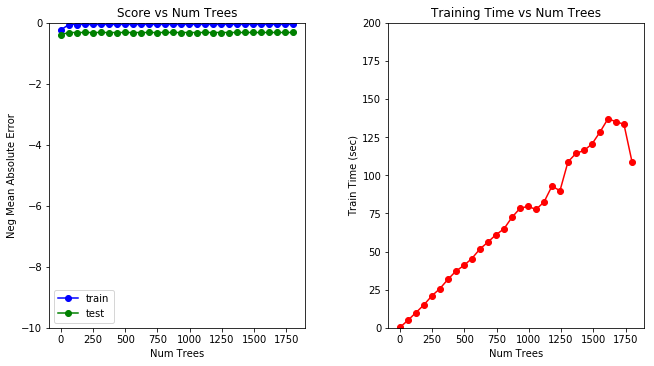

In [37]:
plot_results(tree_grid_search)

In [38]:
#run for 8 min

#Grid with only the 'min_samples_leaf'
tree_grid = {'min_samples_leaf': [1, 2 , 3, 4, 5]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(final_model, param_grid=tree_grid, verbose = False, n_jobs=4, cv = 3,
                                scoring = 'neg_mean_absolute_error')
tree_grid_search.fit(X_train_scaled,y_train);


In [39]:
def plot_results(model, param = 'min_samples_leaf', name = 'min_samples_leaf'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(10, 6))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = -10, ymax = 0)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('Neg Mean Absolute Error')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 20.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

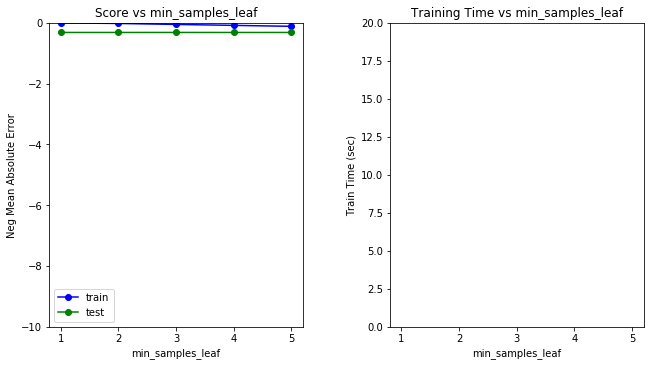

In [40]:
plot_results(tree_grid_search)

In [ ]:
#'max_depth'